# **Carga y procesamiento de datos**

In [2]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
import kagglehub

def cargar_datos():
    df = kagglehub.load_dataset(
        kagglehub.KaggleDatasetAdapter.PANDAS,
        "williamrrubio/data-siniestros-bogot-2015-2021",
        "Data_completa.csv"
    )

    # Procesar fecha
    df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
    df['anio'] = df['fecha'].dt.year
    df['mes'] = df['fecha'].dt.month
    df['dia_semana'] = df['fecha'].dt.dayofweek

    # Codificar gravedad
    gravedad_map = {'Solo danos': 0, 'Con heridos': 1, 'Con muertos': 2}
    df['gravedad_cat'] = df['gravedad'].map(gravedad_map)

    # Imputación
    df['clasevehiculo'] = df['clasevehiculo'].fillna(df['clasevehiculo'].mode()[0])
    df['servicio'] = df['servicio'].fillna("Desconocido")

    # Columnas categóricas (todas)
    cat_cols = ['periodo_dia', 'clase', 'localidad', 'disenolugar',
                'clasevehiculo', 'causa', 'servicio', 'anio', 'mes', 'dia_semana']

    # Codificación ordinal
    encoder = OrdinalEncoder()
    df[cat_cols] = encoder.fit_transform(df[cat_cols])

    X = df[cat_cols]
    y = df['gravedad_cat']

    return X, y

# **Entrenamiento Modelo MLP**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

# === 1. Cargar y dividir datos
X, y = cargar_datos()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# === 2. SMOTE SOLO clase 2 ('Con muertos')
mask_fatal = y_train == 2
X_fatal = X_train[mask_fatal]
target_fatal = y_train[mask_fatal]
n_target = int(len(target_fatal) * 1.5)

smote = SMOTE(sampling_strategy={2: n_target}, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# === 3. Target a one-hot
y_train_cat = to_categorical(y_train_bal, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# === 4. Modelo MLP
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === 5. Entrenamiento
early_stop = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

history = model.fit(
    X_train_bal, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# === 6. Evaluación final
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_cat, axis=1)

print("== Reporte de clasificación ==")
print(classification_report(y_true, y_pred_classes))
print("== Matriz de confusión ==")
print(confusion_matrix(y_true, y_pred_classes))

# Guardar modelo
model.save("models/mlp_model.h5")

<ipython-input-2-7808471a6db6>:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.7391 - loss: 0.6082 - val_accuracy: 0.7823 - val_loss: 0.5266 - learning_rate: 0.0010
Epoch 2/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step - accuracy: 0.7712 - loss: 0.5543 - val_accuracy: 0.7834 - val_loss: 0.5197 - learning_rate: 0.0010
Epoch 3/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.7731 - loss: 0.5503 - val_accuracy: 0.7860 - val_loss: 0.5145 - learning_rate: 0.0010
Epoch 4/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.7746 - loss: 0.5472 - val_accuracy: 0.7839 - val_loss: 0.5165 - learning_rate: 0.0010
Epoch 5/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 82s 3ms/step - accuracy: 0.7749 - loss: 0.5455 - val_accuracy: 0.7853 - val_loss: 0.5131 - learning_rate: 0.0010
Epoch 6/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.7755 - loss: 0.5440 - val_accuracy: 0.7860 - val_loss: 0.5114 - learning_rate: 0.0010
Epoch 7/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step -

== Reporte de clasificación ==
              precision    recall  f1-score   support

           0       0.79      0.93      0.86    128178
           1       0.78      0.55      0.65     69163
           2       0.71      0.02      0.04      3024

    accuracy                           0.79    200365
   macro avg       0.76      0.50      0.51    200365
weighted avg       0.79      0.79      0.77    200365

== Matriz de confusión ==
[[119662   8500     16]
 [ 31026  38129      8]
 [   977   1988     59]]


## **Evaluación del modelo**

6262/6262 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


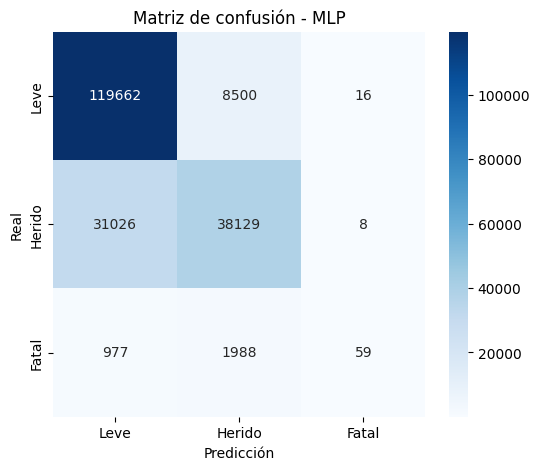

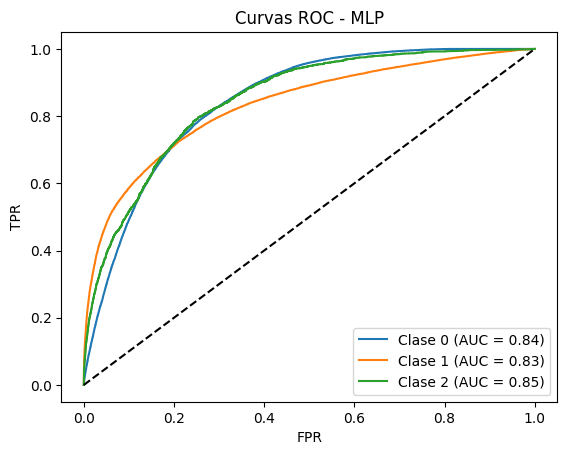

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import json

# === Cargar modelo y datos
model = load_model("/content/models/mlp_model.h5")


# === Predicción
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# === Reporte y matriz
report = classification_report(y_true, y_pred_classes, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# === Matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Leve", "Herido", "Fatal"], yticklabels=["Leve", "Herido", "Fatal"])
plt.title("Matriz de confusión - MLP")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === Curvas ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC - MLP')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()


# **Entrenamiento modelo MLP con embeddings**

In [ ]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import os

# === 1. Cargar datos
X, y = cargar_datos()
X = X.astype(int)  # asegurar enteros

# === 2. División y SMOTE (solo clase 2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
smote = SMOTE(sampling_strategy={2: int(sum(y_train == 2) * 1.5)}, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

y_train_cat = to_categorical(y_train_bal, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# === 3. Calcular pesos por clase
weights = compute_class_weight('balanced', classes=np.unique(y_train_bal), y=y_train_bal)
class_weights = dict(enumerate(weights))

# === 4. Arquitectura con embeddings
inputs = []
embeddings = []

for i in range(X.shape[1]):
    input_i = Input(shape=(1,))
    vocab_size = int(X.iloc[:, i].max()) + 2
    embed_i = Embedding(input_dim=vocab_size, output_dim=8)(input_i)
    flat_i = Flatten()(embed_i)
    inputs.append(input_i)
    embeddings.append(flat_i)

x = Concatenate()(embeddings)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=inputs, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === 5. Preparar inputs separados
X_train_inputs = [X_train_bal.iloc[:, i].values for i in range(X.shape[1])]
X_val_inputs = [X_val.iloc[:, i].values for i in range(X.shape[1])]

# === 6. Entrenamiento
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

history = model.fit(
    X_train_inputs, y_train_cat,
    validation_data=(X_val_inputs, y_val_cat),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# === 7. Guardado
os.makedirs("models", exist_ok=True)
model.save("models/mlp_model_embeddings.keras")
np.savez("models/mlp_embeddings_val_data.npz", X_val=X_val_inputs, y_val=y_val_cat)


<ipython-input-2-7808471a6db6>:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Epoch 1/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.6576 - loss: 0.8041 - val_accuracy: 0.7114 - val_loss: 0.6659 - learning_rate: 0.0010
Epoch 2/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.6862 - loss: 0.7479 - val_accuracy: 0.7014 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 3/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - accuracy: 0.6870 - loss: 0.7311 - val_accuracy: 0.7042 - val_loss: 0.6764 - learning_rate: 0.0010
Epoch 4/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 78s 4ms/step - accuracy: 0.6910 - loss: 0.7086 - val_accuracy: 0.7416 - val_loss: 0.6185 - learning_rate: 0.0010
Epoch 5/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.6962 - loss: 0.6971 - val_accuracy: 0.7092 - val_loss: 0.6559 - learning_rate: 0.0010
Epoch 6/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 47s 4ms/step - accuracy: 0.6968 - loss: 0.6881 - val_accuracy: 0.7269 - val_loss: 0.6309 - learning_rate: 0.0010
Epoch 7/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 85s 4ms/step -

## **Evaluación modelo mlp embeddings**

6262/6262 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
== Reporte de Clasificación ==
              precision    recall  f1-score   support

           0     0.8490    0.8215    0.8350    128178
           1     0.6646    0.5599    0.6078     69163
           2     0.1224    0.7318    0.2097      3024

    accuracy                         0.7298    200365
   macro avg     0.5453    0.7044    0.5508    200365
weighted avg     0.7744    0.7298    0.7471    200365



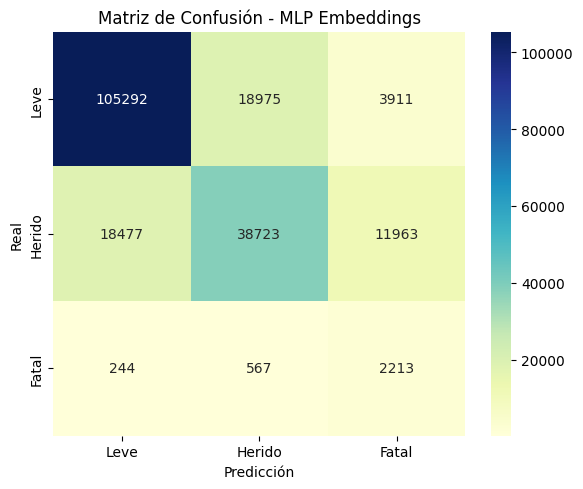

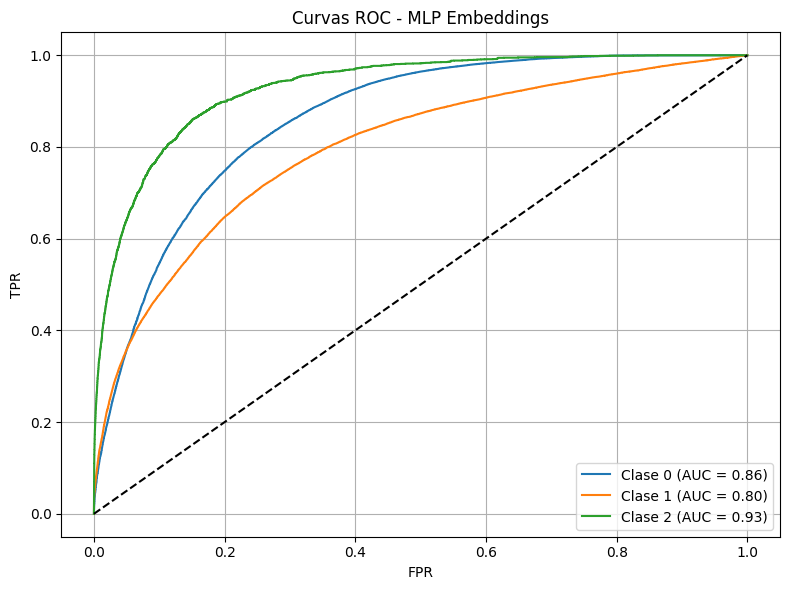

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# === 1. Cargar modelo y datos desde Colab
model = load_model("/content/models/mlp_model_embeddings.keras")
data = np.load("/content/models/mlp_embeddings_val_data.npz", allow_pickle=True)

# Importante: convertir correctamente X_val a lista de arrays
X_val_inputs = [x for x in data["X_val"]]
y_val_cat = data["y_val"]
y_true = np.argmax(y_val_cat, axis=1)

# === 2. Predicción
y_pred = model.predict(X_val_inputs)
y_pred_classes = np.argmax(y_pred, axis=1)

# === 3. Reporte de clasificación
print("== Reporte de Clasificación ==")
print(classification_report(y_true, y_pred_classes, digits=4))

# === 4. Matriz de confusión
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=["Leve", "Herido", "Fatal"],
            yticklabels=["Leve", "Herido", "Fatal"])
plt.title("Matriz de Confusión - MLP Embeddings")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === 5. Curvas ROC y AUC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC - MLP Embeddings')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Entrenamiento del modelo LSTM**

In [3]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os

# === 1. Cargar y dividir datos
X, y = cargar_datos()

# Convertir a enteros y luego a secuencia para LSTM
X_seq = X.astype(int).values  # shape: (n_samples, n_features)

# Ajustar largo a secuencia (padding por filas)
X_seq_padded = pad_sequences(X_seq, maxlen=X_seq.shape[1], padding='post')

X_train, X_val, y_train, y_val = train_test_split(
    X_seq_padded, y, test_size=0.2, stratify=y, random_state=42
)

# === 2. SMOTE solo a clase 2
smote = SMOTE(sampling_strategy={2: int(sum(y_train == 2) * 1.5)}, random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# === 3. One-hot encoding
y_train_cat = to_categorical(y_train_bal, num_classes=3)
y_val_cat = to_categorical(y_val, num_classes=3)

# === 4. Modelo LSTM
vocab_size = int(X_seq.max()) + 2  # tamaño del vocabulario total

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=X_train.shape[1]))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# === 5. Entrenamiento
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5)
]

history = model.fit(
    X_train_bal, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# === 6. Guardar modelo y datos de validación
os.makedirs("models", exist_ok=True)
model.save("models/lstm_model.h5")
np.savez("models/lstm_val_data.npz", X_val=X_val, y_val=y_val_cat)


<ipython-input-2-7808471a6db6>:6: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


12618/12618 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - accuracy: 0.7705 - loss: 0.5458 - val_accuracy: 0.7975 - val_loss: 0.4900 - learning_rate: 0.0010
Epoch 2/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 148s 7ms/step - accuracy: 0.7925 - loss: 0.4975 - val_accuracy: 0.8033 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 3/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.7966 - loss: 0.4856 - val_accuracy: 0.8061 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 4/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.8028 - loss: 0.4694 - val_accuracy: 0.8130 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 5/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.8101 - loss: 0.4530 - val_accuracy: 0.8178 - val_loss: 0.4338 - learning_rate: 0.0010
Epoch 6/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.8157 - loss: 0.4413 - val_accuracy: 0.8232 - val_loss: 0.4244 - learning_rate: 0.0010
Epoch 7/50
12618/12618 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy:

## **Evaluación de modelo LSTM**

6262/6262 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


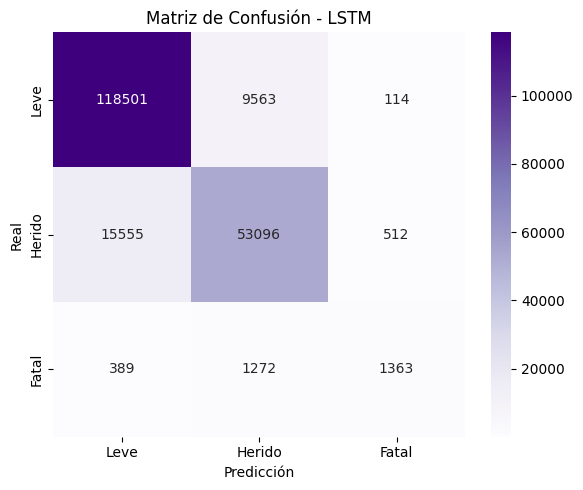

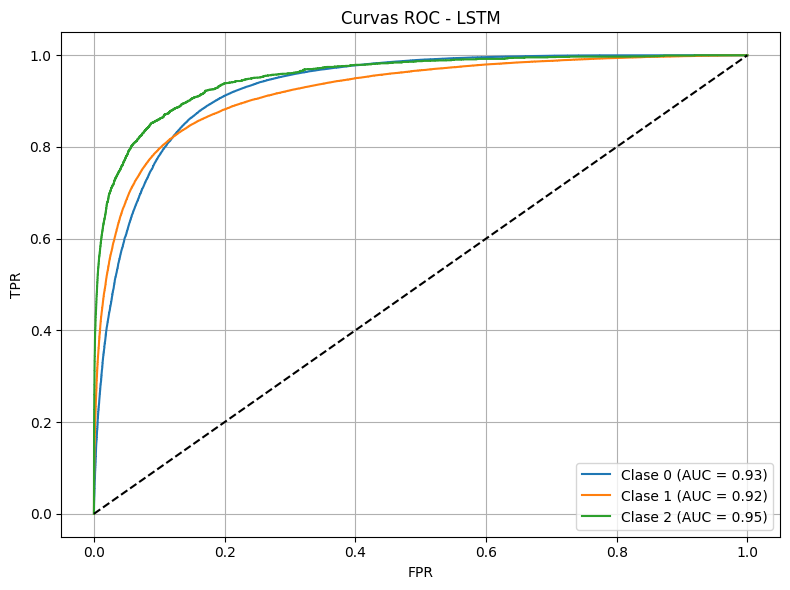

In [6]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

# === 1. Cargar modelo y datos
model = load_model("models/lstm_model.h5")
data = np.load("models/lstm_val_data.npz", allow_pickle=True)
X_val = data["X_val"]
y_val_cat = data["y_val"]
y_true = np.argmax(y_val_cat, axis=1)

# === 2. Predicción
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

# === 3. Reporte
report = classification_report(y_true, y_pred_classes, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# === 4. Guardar JSON
os.makedirs("resultados", exist_ok=True)
with open("resultados/lstm_report.json", "w") as f:
    json.dump({
        "classification_report": report,
        "confusion_matrix": conf_matrix.tolist()
    }, f, indent=4)

# === 5. Matriz de confusión
os.makedirs("resultados/graficos", exist_ok=True)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Leve", "Herido", "Fatal"],
            yticklabels=["Leve", "Herido", "Fatal"])
plt.title("Matriz de Confusión - LSTM")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

# === 6. Curvas ROC
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
fpr = {}
tpr = {}
roc_auc = {}

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr[i], tpr[i], label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC - LSTM')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()